In [1]:
import torch
import os, json, math
from pathlib import Path
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


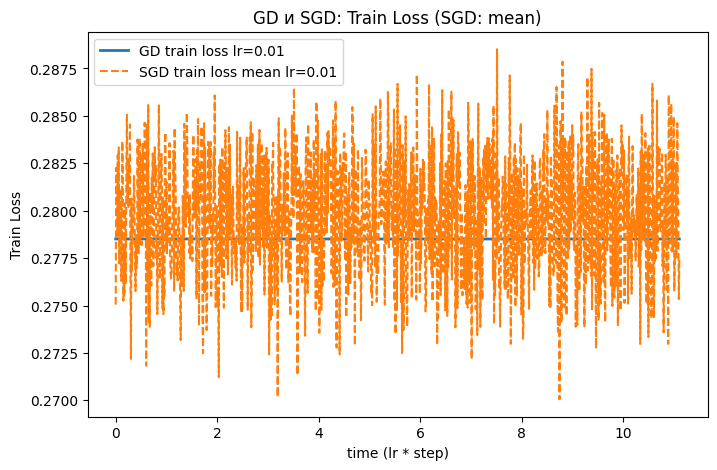

In [ ]:
def get_gd_logs(base_dir, lrs, dtype="float64"):
    gd_train = []
    for lr in lrs:
        logs = json.load(open(os.path.join(base_dir, f"gd_logs_lr{lr}_dtype{dtype}.json")))
        gd_train.append(np.array(logs["train_losses"]))
    return gd_train

def get_sgd_logs(base_dir, lrs, n_traj=1000, traj_len=1111):
    sgd_train = []
    for lr in lrs:
        logs = json.load(open(os.path.join(base_dir, f"sgd_logs_lr{lr}.json")))
        # Each logs[key] is a flat list of length n_traj * traj_len
        def reshape(key):
            arr = np.array(logs[key])
            if arr.size != n_traj * traj_len:
                raise ValueError(f"Expected {n_traj * traj_len} elements in {key}, got {arr.size}")
            return arr.reshape(n_traj, traj_len)
        sgd_train.append(reshape("train_losses"))
    return sgd_train

def plot_gd_and_sgd_together(gd_train, sgd_train, lrs_gd, lrs_sgd):
    """
    Совместная визуализация GD и SGD (только среднее) на одном графике.
    Также добавляет density plot train loss на последней итерации для SGD траекторий.
    """
    plt.figure(figsize=(8,5))
    # GD
    for i, lr in enumerate(lrs_gd):
        steps = np.arange(len(gd_train[i])) * float(lr)
        plt.plot(steps, gd_train[i], label=f"GD train loss lr={lr}", linewidth=2)
    # SGD
    for i, lr in enumerate(lrs_sgd):
        steps = np.arange(sgd_train[i].shape[-1]) * float(lr)
        mean = sgd_train[i].mean(axis=0)
        plt.plot(steps, mean, label=f"SGD train loss mean lr={lr}", linestyle="--")
    plt.xlabel("time (lr * step)")
    plt.ylabel("Train Loss")
    plt.title("GD и SGD: Train Loss (SGD: mean)")
    plt.legend()
    plt.show()

    # Визуализация density train loss на последней итерации для SGD траекторий
    import seaborn as sns
    for i, lr in enumerate(lrs_sgd):
        last_losses = sgd_train[i][:, -1]
        plt.figure(figsize=(8,5))
        sns.histplot(last_losses, kde=True, bins=30, color="skyblue")
        plt.xlabel("Train Loss (SGD, last iteration)")
        plt.ylabel("Density")
        plt.title(f"Density of SGD Train Loss at Last Iteration (lr={lr})")
        plt.grid(True, alpha=0.3)
        plt.show()

BASE_DIR = "./setup1"

# LRS_GD = ["0.1", "0.01"]
# LRS_SGD = ["0.1", "0.01"]

LRS_GD = ["0.01"]
LRS_SGD = ["0.01"]

gd_train = get_gd_logs(BASE_DIR, LRS_GD)
sgd_train = get_sgd_logs(BASE_DIR, LRS_SGD)

# Совместная визуализация GD и SGD + density plot для SGD на последней итерации
plot_gd_and_sgd_together(gd_train, sgd_train, LRS_GD, LRS_SGD)


In [32]:
sgd_train[0].shape

(1111000,)

## Hessians stats

## REPLACEMENT = FALSE

In [46]:
BASE_DIR = "./setup1" 
# LRS_TO_USE = ["0.001","0.0001"]  # "0.01" или "0.1"
# LRS_TO_USE =["0.1"]
LRS_TO_USE = ["0.01","0.05", "0.005", "0.001"]
W_SGD =[]
for LR_TO_USE in LRS_TO_USE:
    PATH = os.path.join(BASE_DIR, f"sgd_weights_lr{LR_TO_USE}.pt")  # ожидаем shape [N, T, D]
    W_SGD.append(torch.load(PATH, map_location="cpu").detach())
W_SGD[0].shape


torch.Size([1000, 1111, 386])

In [47]:
BASE_DIR = "./setup1"
LRS_TO_USE = ["0.01","0.05", "0.005", "0.001"]
W_GD = []
for LR_TO_USE in LRS_TO_USE:
    PATH = os.path.join(BASE_DIR, f"gd_weights_lr{LR_TO_USE}_dtypefloat64.pt")
    W_GD.append(torch.load(PATH, map_location="cpu"))
print(W_GD[0].shape)


torch.Size([1111, 386])


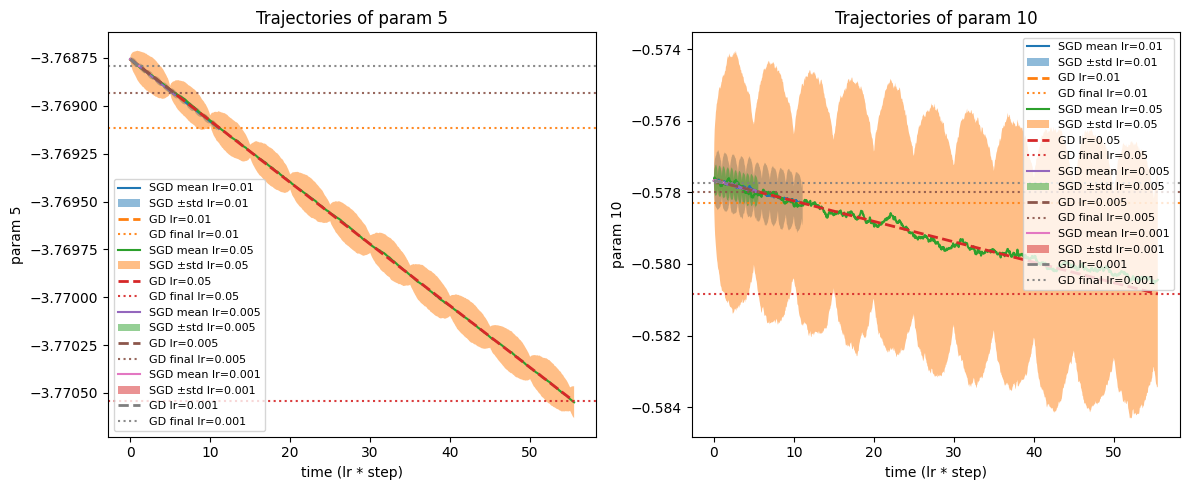

In [48]:
params = [5, 10]  # список параметров для отображения
n_params = len(params)

fig, axes = plt.subplots(1, n_params, figsize=(6 * n_params, 5), sharex=False, sharey=False)

if n_params == 1:
    axes = [axes]  # чтобы всегда был список

for ax, p in zip(axes, params):
    for i, lr in enumerate([float(x) for x in LRS_TO_USE]):
        # SGD: [N, T, D] → float64
        trajs = W_SGD[i][:, :, p].to(torch.float64).numpy()
        mean_traj = trajs.mean(axis=0)
        std_traj = trajs.std(axis=0)

        t_sgd = lr * np.arange(trajs.shape[1])

        ax.plot(t_sgd, mean_traj, label=f"SGD mean lr={lr}")
        ax.fill_between(
            t_sgd,
            mean_traj - std_traj,
            mean_traj + std_traj,
            alpha=0.5,
            label=f"SGD ±std lr={lr}"
        )

        # GD: [T, D] → float64
        traj_gd = W_GD[i][:, p].to(torch.float64).numpy()
        t_gd = lr * np.arange(len(traj_gd))

        ax.plot(t_gd, traj_gd, "--", linewidth=2, label=f"GD lr={lr}")

        # горизонтальная линия по финальной точке GD
        final_val = traj_gd[-1]
        ax.axhline(
            final_val,
            linestyle=":",
            color=ax.lines[-1].get_color(),
            alpha=0.9,
            label=f"GD final lr={lr}"
        )

    ax.set_xlabel("time (lr * step)")
    ax.set_ylabel(f"param {p}")
    ax.set_title(f"Trajectories of param {p}")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


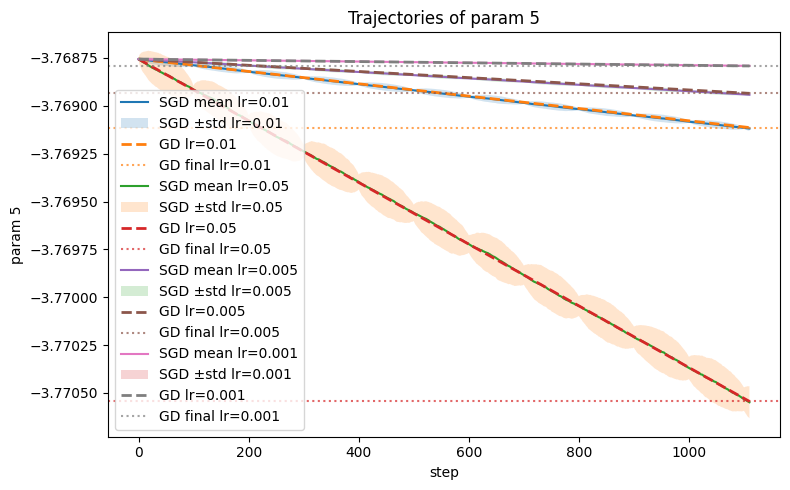

In [49]:
p = 5  # индекс параметра
plt.figure(figsize=(8, 5))

for i, lr in enumerate([float(x) for x in LRS_TO_USE]):
    # SGD: [N, T, D] → в float64
    trajs = W_SGD[i][:, :, p].to(torch.float64).numpy()  # shape [N, T]
    mean_traj = trajs.mean(axis=0)
    std_traj = trajs.std(axis=0)

    t_sgd = np.arange(trajs.shape[1])

    plt.plot(t_sgd, mean_traj, label=f"SGD mean lr={lr}")
    plt.fill_between(
        t_sgd,
        mean_traj - std_traj,
        mean_traj + std_traj,
        alpha=0.2,
        label=f"SGD ±std lr={lr}"
    )

    # GD: [T, D] → тоже в float64
    traj_gd = W_GD[i][:, p].to(torch.float64).numpy()
    t_gd = np.arange(len(traj_gd))

    plt.plot(t_gd, traj_gd, "--", linewidth=2, label=f"GD lr={lr}")

    # горизонтальная линия по финальной точке GD
    final_val = traj_gd[-1]
    plt.axhline(
        final_val,
        linestyle=":",
        color=plt.gca().lines[-1].get_color(),
        alpha=0.7,
        label=f"GD final lr={lr}"
    )

plt.xlabel("step")
plt.ylabel(f"param {p}")
plt.title(f"Trajectories of param {p}")
plt.legend()
plt.tight_layout()
plt.show()


## REPLACEMENT = TRUE

In [50]:
BASE_DIR = "./setup2" 

# LRS_TO_USE =["0.1"]
LRS_TO_USE = ["0.01","0.05", "0.005", "0.001"]
W_SGD =[]
for LR_TO_USE in LRS_TO_USE:
    PATH = os.path.join(BASE_DIR, f"sgd_weights_lr{LR_TO_USE}.pt")  # ожидаем shape [N, T, D]
    W_SGD.append(torch.load(PATH, map_location="cpu").detach())
W_SGD[0].shape


torch.Size([1000, 1111, 386])

In [51]:
BASE_DIR = "./setup2"
# LRS_TO_USE =[ "0.1"]
LRS_TO_USE = ["0.01","0.05", "0.005", "0.001"]
W_GD = []
for LR_TO_USE in LRS_TO_USE:
    PATH = os.path.join(BASE_DIR, f"gd_weights_lr{LR_TO_USE}_dtypefloat64.pt")
    W_GD.append(torch.load(PATH, map_location="cpu"))
print(W_GD[0].shape)


torch.Size([1111, 386])


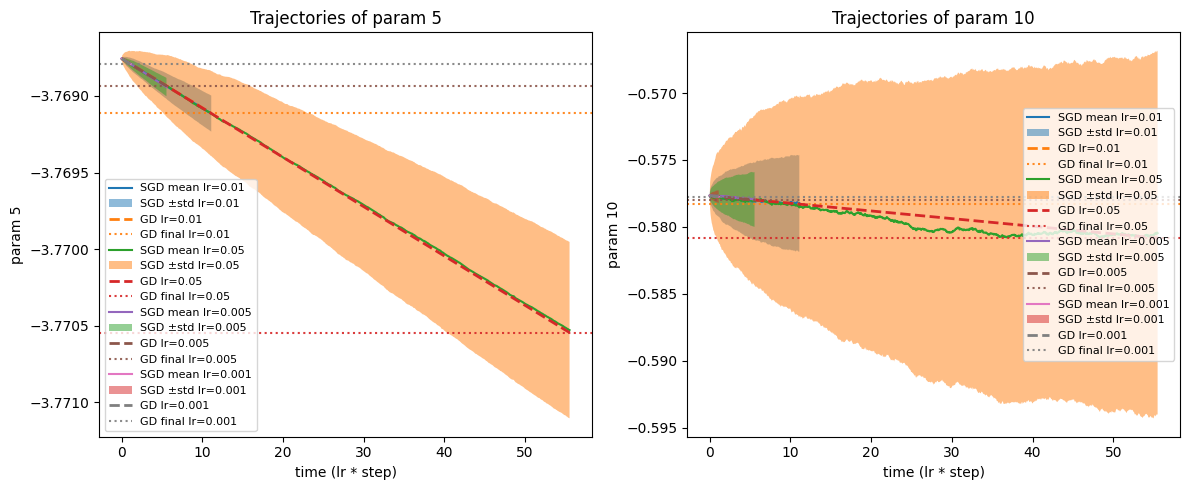

In [52]:
params = [5, 10]  # список параметров для отображения
n_params = len(params)

fig, axes = plt.subplots(1, n_params, figsize=(6 * n_params, 5), sharex=False, sharey=False)

if n_params == 1:
    axes = [axes]  # чтобы всегда был список

for ax, p in zip(axes, params):
    for i, lr in enumerate([float(x) for x in LRS_TO_USE]):
        # SGD: [N, T, D] → float64
        trajs = W_SGD[i][:, :, p].to(torch.float64).numpy()
        mean_traj = trajs.mean(axis=0)
        std_traj = trajs.std(axis=0)

        t_sgd = lr * np.arange(trajs.shape[1])

        ax.plot(t_sgd, mean_traj, label=f"SGD mean lr={lr}")
        ax.fill_between(
            t_sgd,
            mean_traj - std_traj,
            mean_traj + std_traj,
            alpha=0.5,
            label=f"SGD ±std lr={lr}"
        )

        # GD: [T, D] → float64
        traj_gd = W_GD[i][:, p].to(torch.float64).numpy()
        t_gd = lr * np.arange(len(traj_gd))

        ax.plot(t_gd, traj_gd, "--", linewidth=2, label=f"GD lr={lr}")

        # горизонтальная линия по финальной точке GD
        final_val = traj_gd[-1]
        ax.axhline(
            final_val,
            linestyle=":",
            color=ax.lines[-1].get_color(),
            alpha=0.9,
            label=f"GD final lr={lr}"
        )

    ax.set_xlabel("time (lr * step)")
    ax.set_ylabel(f"param {p}")
    ax.set_title(f"Trajectories of param {p}")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


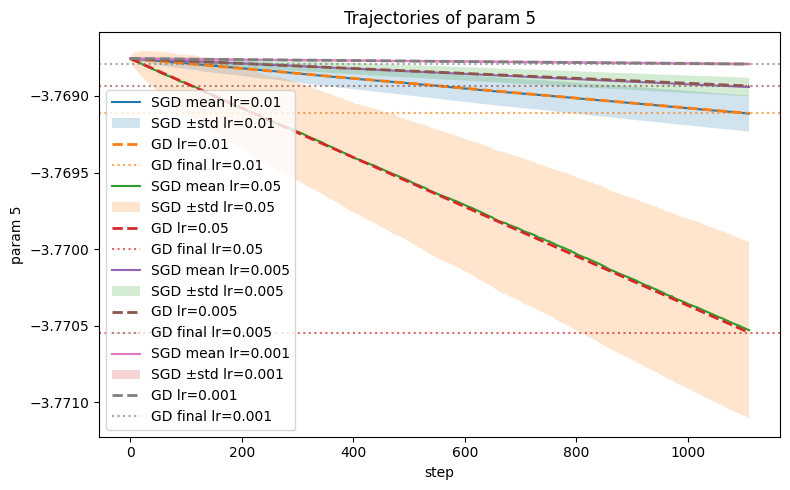

In [53]:
p = 5  # индекс параметра
plt.figure(figsize=(8, 5))

for i, lr in enumerate([float(x) for x in LRS_TO_USE]):
    # SGD: [N, T, D] → в float64
    trajs = W_SGD[i][:, :, p].to(torch.float64).numpy()  # shape [N, T]
    mean_traj = trajs.mean(axis=0)
    std_traj = trajs.std(axis=0)

    t_sgd = np.arange(trajs.shape[1])

    plt.plot(t_sgd, mean_traj, label=f"SGD mean lr={lr}")
    plt.fill_between(
        t_sgd,
        mean_traj - std_traj,
        mean_traj + std_traj,
        alpha=0.2,
        label=f"SGD ±std lr={lr}"
    )

    # GD: [T, D] → тоже в float64
    traj_gd = W_GD[i][:, p].to(torch.float64).numpy()
    t_gd = np.arange(len(traj_gd))

    plt.plot(t_gd, traj_gd, "--", linewidth=2, label=f"GD lr={lr}")

    # горизонтальная линия по финальной точке GD
    final_val = traj_gd[-1]
    plt.axhline(
        final_val,
        linestyle=":",
        color=plt.gca().lines[-1].get_color(),
        alpha=0.7,
        label=f"GD final lr={lr}"
    )

plt.xlabel("step")
plt.ylabel(f"param {p}")
plt.title(f"Trajectories of param {p}")
plt.legend()
plt.tight_layout()
plt.show()


## THE END

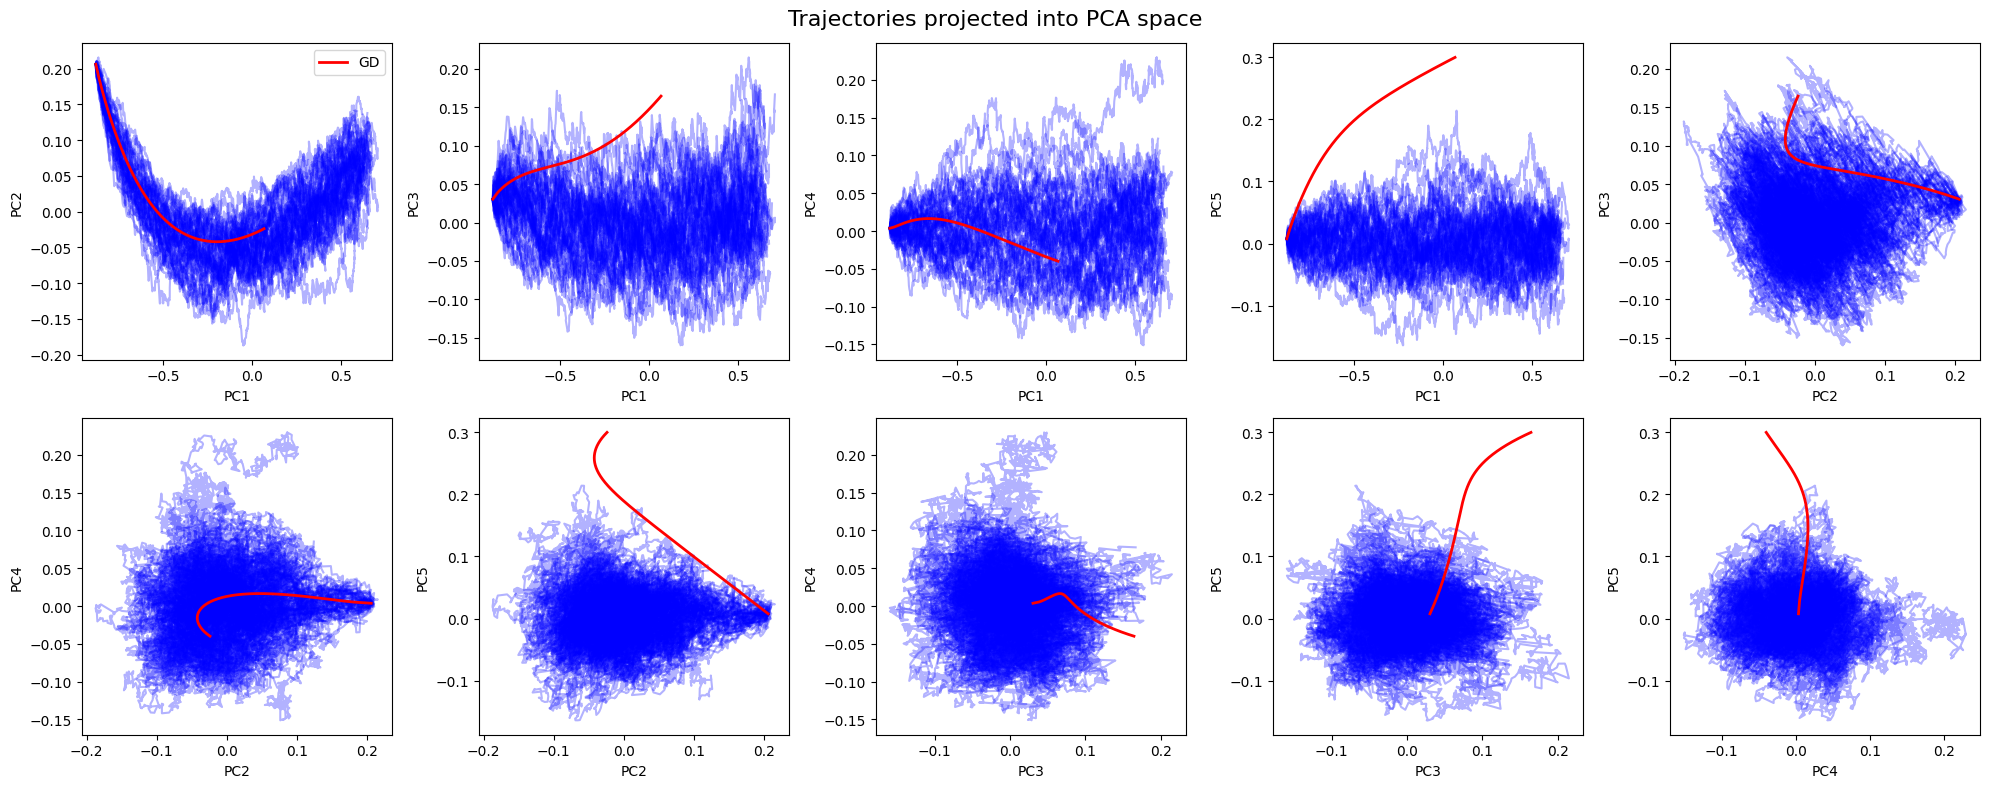

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# допустим W_SGD: [n_trials, T, d]
# допустим W_GD:  [1, T, d]

pairs = [(0,1), (0,2), (0,3), (0,4),
         (1,2), (1,3), (1,4),
         (2,3), (2,4),
         (3,4)]

# Берём все траектории SGD
n_trials, T, d = W_SGD.shape

# Для PCA склеиваем все траектории по времени и по траекториям
X = W_SGD.reshape(-1, d)  # [n_trials*T, d]

# Центрируем и делаем PCA
pca = PCA(n_components=5)
X_proj = pca.fit_transform(X)   # [n_trials*T, 5]

# Возвращаем в форму [n_trials, T, 5]
X_proj = X_proj.reshape(n_trials, T, -1)

# Теперь проекция GD
gd_proj = pca.transform(W_GD)   # [T, 5]

# --- Визуализация ---
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]
    # SGD trajectories
    for trial in range(min(50, n_trials)):   # рисуем не все, чтобы не захламлять
        ax.plot(X_proj[trial, :, i], X_proj[trial, :, j], alpha=0.3, color="blue")
    # GD trajectory
    ax.plot(gd_proj[:, i], gd_proj[:, j], color="red", linewidth=2, label="GD" if idx == 0 else "")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    if idx == 0:
        ax.legend()

fig.suptitle("Trajectories projected into PCA space", fontsize=16)
plt.tight_layout()
plt.show()


## STABILITY: different lr


In [74]:
import os
import torch

BASE_DIR = "./setup1"
# LRs_TO_USE = [
#     "0.1","0.05","0.01","0.005",
#     "0.001","0.0005","0.0001","5e-05","1e-05"
# ]

LRs_TO_USE = ["0.1", "0.01"]

W_array = []
for LR_TO_USE in LRs_TO_USE:
    PATH = os.path.join(BASE_DIR, f"gd_weights_lr{LR_TO_USE}_dtypefloat64.pt")
    # грузим как есть, без .float()
    W = torch.load(PATH, map_location="cpu")

    # если нужно гарантировать float64:
    # W = W.to(torch.float64)

    # ожидаем [N, T, D]
    print(PATH, W.shape, W.dtype)
    W_array.append(W)


./setup1/gd_weights_lr0.1_dtypefloat64.pt torch.Size([1111, 386]) torch.float64
./setup1/gd_weights_lr0.01_dtypefloat64.pt torch.Size([1111, 386]) torch.float64


In [75]:
W_array[0][0][0].dtype


torch.float64

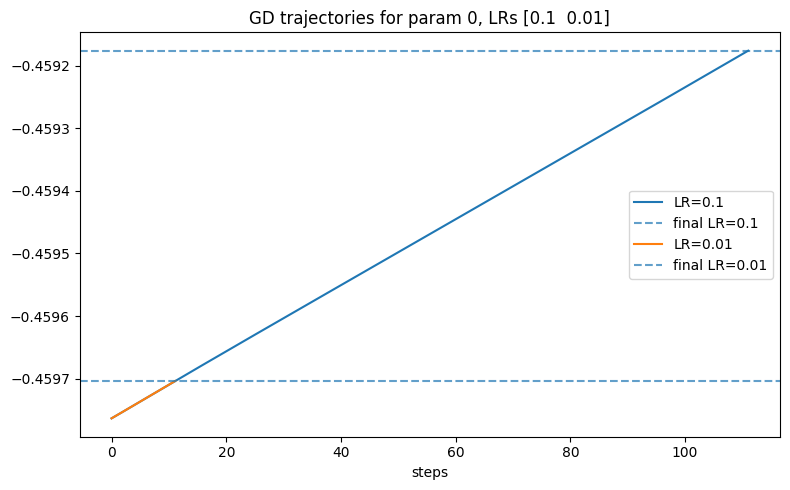

In [77]:
import numpy as np
import matplotlib.pyplot as plt

params = [0]

lrs = np.array([float(lr) for lr in LRs_TO_USE])

# идём по парам соседних lr
for i in range(len(lrs) - 1):
    curr_lrs = lrs[i:i+2]
    curr_W = W_array[i:i+2]

    for p in params:
        plt.figure(figsize=(8, 5))

        for lr, W in zip(curr_lrs, curr_W):
            traj = W[:, p].numpy()   # сама траектория параметра
            # рисуем траекторию

            plt.plot( lr * np.arange(len(traj)), traj, label=f"LR={lr}")

            # горизонтальная линия по конечной точке
            final_val = traj[-1]
            plt.axhline(final_val, linestyle="--", alpha=0.7, label=f"final LR={lr}")

        plt.legend()
        plt.xlabel("steps")
        plt.title(f"GD trajectories for param {p}, LRs {curr_lrs}")
        plt.tight_layout()
        plt.show()
